# Setup

In [3]:
import stan
import pandas as pd
import numpy as np
import scipy.stats as stats 
import matplotlib
import arviz as az
import matplotlib.pyplot as plt
#matplotlib.rcParams['figure.figsize']=5,5
matplotlib.rcParams['figure.dpi']=100
#plt.style.use('ggplot')
from IPython.display import Image

In [4]:
# this is a work around found at 
# https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop-in-spyd
import nest_asyncio
nest_asyncio.apply()

## Import and prepare data

In [5]:
# Import data: practices performed in each clinic during 40 days
data0 = pd.read_csv('Medical-practices.csv', index_col=0)
# Prepare a slice of data that conserves last day, but deletes previous 10 days.  
# In this way we are more sensitive to a change that started within the last 10 days
# since we'll not use that block to learn the pattern
start_not_learning_block=-11
end_not_learning_block=-1
data = data0.iloc[np.r_[-len(data0):start_not_learning_block,end_not_learning_block:end_not_learning_block+1],:]
# Let's see first and last 2 rows
data.iloc[[-len(data),-len(data)+1,-2,-1],:]

,Date,Clinic #0,Clinic #1,Clinic #2,Clinic #3,Clinic #4,Clinic #5,Clinic #6,Clinic #7,Clinic #8,...,Clinic #48,Clinic #49,Clinic #50,Clinic #51,Clinic #52,Clinic #53,Clinic #54,Clinic #55,Clinic #56,Clinic #57
0,2024-08-05,38.0,52.0,81.0,40.0,54.0,26.0,22.0,14.0,30.0,...,42.0,260.0,47.0,15.0,16.0,19.0,298.0,412.0,18.0,1139.0
1,2024-08-06,36.0,41.0,101.0,63.0,43.0,29.0,32.0,14.0,39.0,...,41.0,222.0,46.0,13.0,22.0,21.0,265.0,461.0,15.0,1426.0
28,2024-09-02,42.0,64.0,99.0,36.0,44.0,18.0,32.0,35.0,43.0,...,38.0,249.0,51.0,7.0,15.0,38.0,244.0,462.0,11.0,1347.0
39,2024-09-13,25.0,37.0,59.0,15.0,39.0,20.0,17.0,8.0,31.0,...,27.0,161.0,35.0,16.0,18.0,12.0,246.0,293.0,8.0,866.0


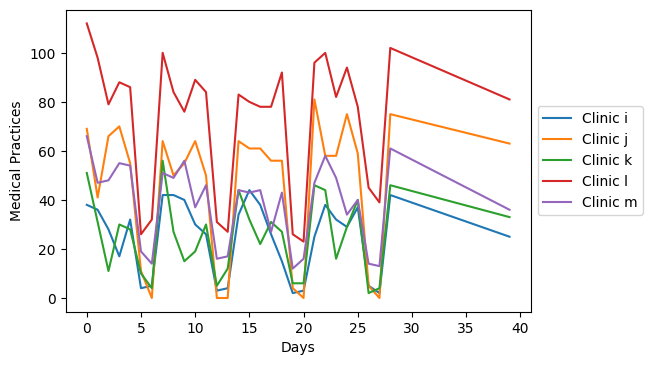

In [6]:
# We verify the hypothesis: there is an approximate ratio in practices for all clinics
# And fluctuations we assume that come from the draw of a Poisson with a given rate
plt.plot(data[list(data)[1]], label='Clinic i')
plt.plot(data[list(data)[12]], label='Clinic j')
plt.plot(data[list(data)[17]], label='Clinic k')
plt.plot(data[list(data)[19]], label='Clinic l')
plt.plot(data[list(data)[15]], label='Clinic m')
plt.xlabel('Days')
plt.ylabel('Medical Practices')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Bayesian modeling with STAN

We model the number o medical practices performed by clinic $n$ on day $t$ as being drawn from a Poisson distribution whose rate is the product of clinic $n$ size time the given day $t$ <i>magnitude</i>:
$$ practices \sim Poisson (s_n\, d_t)$$


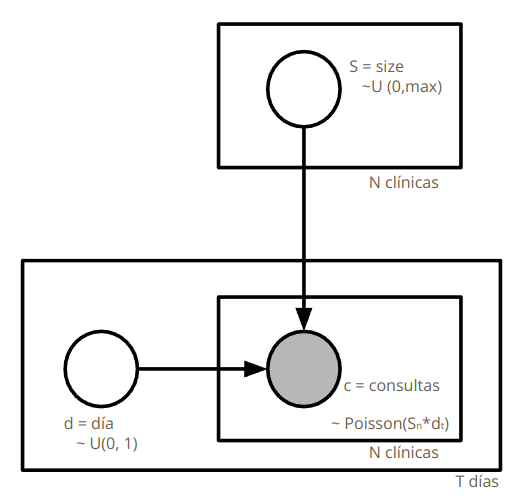

In [7]:
Image("graphical_model.png")

In [20]:
# Let's define the aforementioned model to be executed with Stan
my_basic_model="""
data {
 int <lower=0> N; // number of clinics
 int <lower=0> T; // number of days in the dataset
 int <lower=0> my_max; // maximum number of practices in the dataset (used to break degeneracy)
 array[T,N] int<lower=0> practices;  // practices on day t in clinic n: practices[t,n] 
}

parameters {
  vector<lower=0, upper=1>[T] d; // parameter that measures how 'hot' is each day
  vector<lower=0, upper=my_max>[N] s; // parameter that estimates the size of each clinic
  // Challenge: include in the model 
  // 1- Some days a doctor may not come and the clinic is smaller for that day
  // 2- People leaves a clinic if there is a long wait... can you do it?
  
}

model {
   for (n in 1:N) {
       for (t in 1:T) {           
           practices[t,n] ~ poisson( d[t]*s[n] );
     }; 
     };
}
"""

# Let's define the aforementioned model to be executed with Stan
my_model_with_missing_and_waiting="""
data {
 int <lower=0> N; // number of clinics
 int <lower=0> T; // number of days in the dataset
 int <lower=0> my_max; // maximum number of practices in the dataset (used to break degeneracy)
 array[T,N] int<lower=0> practices;  // practices on day t in clinic n: practices[t,n] 
}

parameters {
  vector<lower=0, upper=1>[T] d; // parameter that measures how 'hot' is each day
  vector<lower=0, upper=my_max>[N] s; // parameter that estimates the size of each clinic
  real<lower=0> eps;
  // Challenge: include in the model 
  // 1- Some days a doctor may not come and the clinic is smaller for that day
  // 2- People leaves a clinic if there is a long wait... can you do it?
  
}

model {
   for (n in 1:N) {
       for (t in 1:T) {           
           eps ~ normal(0, d[t]*s[n]/10 );
           practices[t,n] ~ poisson( d[t]*s[n] - eps );
     }; 
     };
}
"""

In [21]:
# We define the dictionary that contains the data the model needs
# Do you understand why the my_max variable is used to break a degeneracy ?
practices = np.array(data[list(data)[1:]]).astype(int)
my_data = {'N':practices.shape[1], 'T':practices.shape[0], 'my_max': int(data[list(data)[1:]].max().max()), 'practices': practices }

In [33]:
# Plug the data in the model and build it
# One of the models has less parameters, but it will be shown to be too restricted (not good convergence)
#model = stan.build(my_basic_model, data=my_data, random_seed=1);
model = stan.build(my_model_with_missing_and_waiting, data=my_data, random_seed=1);

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [34]:
# We fit the model: we cample from the posterior
fit = model.sample(num_chains=4, num_samples=1000)#, num_warmup=1000, delta=0.9)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  34% (2700/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  55% (4400/8000)
Sampling:  71% (5700/8000)
Sampling:  86% (6900/8000)
Sampling:  91% (7300/8000)
Sampling:  92% (7400/8000)
Sampling:  98% (7800/8000)
Sampling: 100% (8000/8000)
Sampl

In [35]:
# We display the info in a dataframe to work it out more easily
df = fit.to_frame() 
df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,d.1,d.2,d.3,...,s.50,s.51,s.52,s.53,s.54,s.55,s.56,s.57,s.58,eps
draws,,,,,,,,,,,,,,,,,,,,,
0,436211.147390,0.995930,0.138901,5.0,31.0,0.0,-436171.151482,0.885396,0.954265,0.823632,...,263.169042,55.033852,14.733165,17.899590,29.310229,292.243936,485.110456,14.605864,1402.092430,0.001783
1,436220.799058,0.985984,0.098198,5.0,31.0,0.0,-436185.059890,0.910245,0.927491,0.804409,...,260.920097,51.811574,15.878584,17.566640,29.766652,284.715885,481.249953,16.851929,1395.402748,0.000352
2,436225.838622,0.892295,0.205108,4.0,15.0,0.0,-436187.505200,0.873017,0.888088,0.790325,...,275.194871,59.506775,14.752412,18.315172,29.857612,296.003062,501.215207,14.433976,1435.165923,0.003576
3,436218.027471,0.975862,0.213728,4.0,15.0,0.0,-436180.353923,0.862928,0.904360,0.792620,...,277.457893,56.891591,15.683979,20.106927,29.089808,298.440745,501.515503,15.198256,1426.397051,0.001275
4,436211.472731,0.965737,0.138901,5.0,31.0,0.0,-436158.147870,0.898220,0.904535,0.802216,...,261.099024,55.577999,13.029453,17.108880,27.799477,287.517940,482.846667,15.398371,1395.997439,0.009330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,436222.163026,0.926386,0.213728,4.0,15.0,0.0,-436167.957553,0.891360,0.927458,0.788034,...,266.023335,54.471225,16.145734,19.855356,30.815322,287.340122,489.341304,15.503321,1438.960895,0.006440
3996,436225.220640,0.931839,0.138901,5.0,31.0,0.0,-436172.455106,0.887278,0.934755,0.827242,...,261.212854,52.724478,14.195566,20.209092,31.313420,292.861078,475.620588,14.354169,1384.381408,0.001036
3997,436226.036107,0.988182,0.098198,5.0,31.0,0.0,-436185.885688,0.887727,0.933934,0.822708,...,264.985921,55.535496,14.026862,18.234242,30.464220,286.382691,487.280170,15.735694,1384.152155,0.004689


In [36]:
# Let's diagnose the sampling.  rhat is a variable that measures how good the chains have reached a stationary state
# rhat < 1.05 is good enough
azdata = az.from_pystan(fit)
summary = az.summary(azdata)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d[0],0.882,0.020,0.846,0.919,0.002,0.001,176.0,387.0,1.02
d[1],0.923,0.020,0.887,0.963,0.002,0.001,144.0,387.0,1.03
d[2],0.809,0.019,0.777,0.847,0.001,0.001,182.0,416.0,1.02
d[3],0.827,0.019,0.792,0.863,0.002,0.001,170.0,433.0,1.02
d[4],0.674,0.016,0.643,0.705,0.001,0.001,184.0,438.0,1.02
...,...,...,...,...,...,...,...,...,...
s[54],291.803,6.497,279.408,303.617,0.536,0.380,152.0,373.0,1.02
s[55],488.131,9.733,469.305,505.172,0.870,0.616,133.0,318.0,1.03
s[56],15.498,0.966,13.655,17.291,0.028,0.020,1148.0,1235.0,1.00
s[57],1408.990,23.459,1363.999,1438.986,2.265,1.606,134.0,312.0,1.03


The rhat should be below 1.01 (1.05 acceptable) to have a fully confident sampling.  It is "ok"

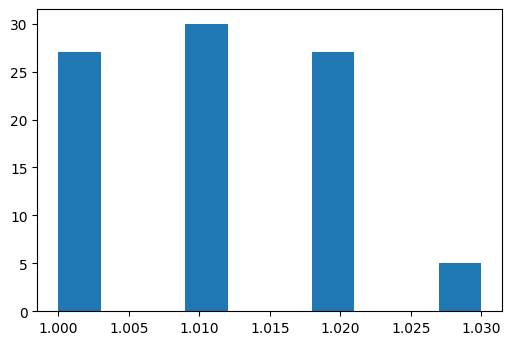

In [44]:
plt.hist(summary['r_hat'])
plt.show()

### Let's sort the clinics

We sort them from most unlikely because of being above the expectation, to the most unlikey of being below the expectation.  All this corresponds to the given day of study "$d_0$" in which we are testing the anomaly.

We can compute the average p-value 
$$\langle p_n \rangle = \langle \sum_{x=practices[n]@d_0}^\infty Poisson(x; d_0 \cdot s[n]) \rangle $$
for every clinic $n$, where $d_0$  is the day of study.  The clinic that has the minimum $\langle p_n \rangle$ is the most unlikely from above, that we're looking for.

In [45]:
# Dataframe with all the required info to compute <p_n>
my_day = df[['d.'+str(len(data))]+['s.'+str(i+1) for i in range(len(list(data))-1)]]
my_day[:4]

parameters,d.30,s.1,s.2,s.3,s.4,s.5,s.6,s.7,s.8,s.9,...,s.49,s.50,s.51,s.52,s.53,s.54,s.55,s.56,s.57,s.58
draws,,,,,,,,,,,,,,,,,,,,,
0,0.627543,37.324716,51.215436,100.955815,41.474525,40.691021,42.175040,27.354464,29.898320,43.222856,...,47.794069,263.169042,55.033852,14.733165,17.899590,29.310229,292.243936,485.110456,14.605864,1402.092430
1,0.606511,36.340377,48.991141,96.814789,44.396150,41.021491,42.314939,24.642873,27.928937,41.114863,...,47.367958,260.920097,51.811574,15.878584,17.566640,29.766652,284.715885,481.249953,16.851929,1395.402748
2,0.616861,37.363732,53.854421,100.011193,46.254812,46.322796,39.417670,27.194290,29.870906,41.008721,...,45.933325,275.194871,59.506775,14.752412,18.315172,29.857612,296.003062,501.215207,14.433976,1435.165923
3,0.604440,39.651418,54.464680,96.646358,44.647308,42.523013,39.705376,24.200390,29.770430,41.452151,...,48.085351,277.457893,56.891591,15.683979,20.106927,29.089808,298.440745,501.515503,15.198256,1426.397051


In [39]:
clinics = list(data)[1:] # starts at 1 because column 0 is the date
probabilities = pd.DataFrame()
for i in range(len(clinics)):
    if i % 10 ==0: print(i,'/',len(clinics))
    tmp = []
    for k in range(len(my_day)):  # we run over all samples of the posterior
        # Here instead of summing to infinity we use the CDF of the Poisson distribution
        # tmp is a list of each p-value for each posterior sample
        tmp.append( 1 - stats.poisson.cdf(data.iloc[-1][clinics[i]], my_day.iloc[k]['d.'+str(len(data))] * my_day.iloc[k]['s.'+str(i+1)])) # i+1 because the Stan numbering starts at 1: clinic[i] has size s."i+1"
    # Create a column in dataframe "probabilities" corresponding to the i-th clinic
    probabilities[clinics[i]] = [np.mean(tmp), np.std(tmp),int(data.iloc[-1][clinics[i]]), np.mean(my_day['d.'+str(len(data))]) * np.mean(my_day['s.'+str(i+1)]), [my_day.iloc[k]['d.'+str(len(data))] * my_day.iloc[k]['s.'+str(i+1)] for k in range(len(my_day))]]
# Assign a name to each row in the dataframe
probabilities.index = ['<p_n>','SD(p_n)','practices_at_testing_day','Poisson_mean_rate', 'rate_list']

0 / 58
10 / 58
20 / 58
30 / 58
40 / 58
50 / 58


In [40]:
# Let's sort this new dataframe from less likely by being above expectation, to less likely by being below expectation.
probabilities.sort_values(by = '<p_n>', axis = 1, inplace=True) 
probabilities

,Clinic #54,Clinic #11,Clinic #12,Clinic #26,Clinic #4,Clinic #46,Clinic #51,Clinic #33,Clinic #52,Clinic #16,...,Clinic #27,Clinic #15,Clinic #40,Clinic #53,Clinic #34,Clinic #20,Clinic #3,Clinic #7,Clinic #25,Clinic #23
<p_n>,0.000008,0.006013,0.00658,0.008716,0.011841,0.012101,0.014843,0.027149,0.038468,0.044403,...,0.866801,0.887695,0.900254,0.932432,0.989094,0.989627,0.989986,0.99385,0.995972,0.998365
SD(p_n),0.000017,0.003972,0.004197,0.005169,0.006869,0.01337,0.008181,0.013319,0.017536,0.019971,...,0.039436,0.035011,0.035943,0.023762,0.005903,0.005175,0.005111,0.003162,0.002142,0.00088
consultas_my_day,246,63,26,20,39,482,16,19,18,33,...,15,10,37,12,40,12,15,8,8,3
Poisson_mean_rate,182.469817,45.316976,15.651393,11.52013,26.847422,431.602608,9.190248,12.213585,11.936527,24.586914,...,20.586712,15.231199,46.311697,18.872596,57.485557,22.976039,26.984347,18.434955,19.149531,12.604111
rate_list,"[183.39554313048086, 172.683318609431, 182.592...","[45.1022398636155, 45.13117485974572, 46.39707...","[15.41765972499896, 15.933928506857123, 15.802...","[11.041348907032544, 11.992937009210294, 12.67...","[25.535352271028867, 24.879986206724165, 28.57...","[439.704839509688, 412.7533707142527, 440.8178...","[9.245690077263916, 9.630535749327537, 9.10019...","[12.71662494774252, 11.484809077632718, 11.678...","[11.232756429224253, 10.654360750670772, 11.29...","[25.507227534081917, 24.025352534403577, 26.06...",...,"[19.30919497138256, 19.762417057319226, 20.661...","[15.68903374974761, 15.298815338083159, 15.648...","[43.65687084646865, 44.52916971982706, 46.3113...","[18.393419863656593, 18.053802004269095, 18.41...","[57.95373917487952, 53.85318699879998, 57.4049...","[22.342291535597926, 20.944926049532633, 23.18...","[26.02703433371269, 26.92675373762191, 28.5327...","[18.76247195932265, 16.939207662420223, 18.426...","[18.65882998927164, 19.49933648642559, 19.0636...","[13.077818869100103, 11.684447615056019, 13.42..."


## Result!

Let's plot the first and last clinics in the "probabilities" dataframe

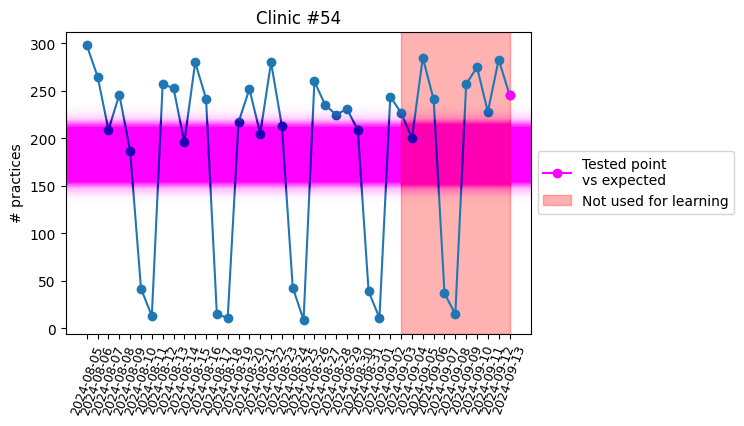

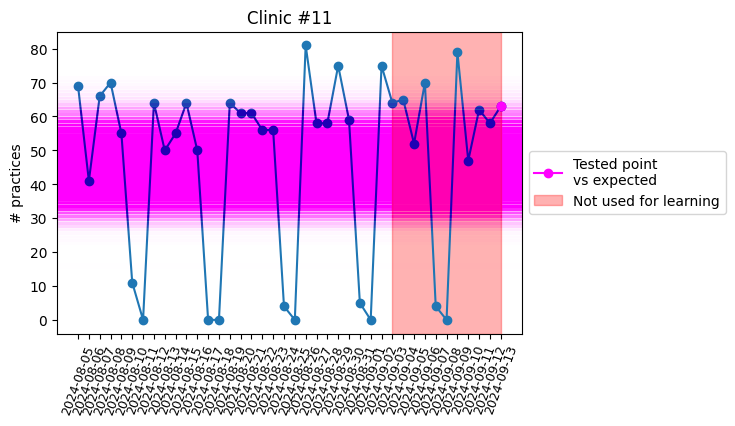

In [43]:
for name in list(probabilities)[:2]: 
    plt.plot(np.array(data0['Date'][:]), np.array(data0[name][:]),marker='o')
    plt.plot(np.array(data0['Date'])[-1], np.array(data0[name])[-1],marker='o',color='magenta', label='Tested point\nvs expected')
    #plt.scatter(np.array(data['Fecha'])[-day_of_study-1], np.array(data[name])[-day_of_study-1],marker='o',color='magenta', label='Tested point')
    plt.axvspan(np.array(data0['Date'])[start_not_learning_block],np.array(data0['Date'])[end_not_learning_block], alpha=0.3, color='red', label='Not used for learning')
    for i in range(len(probabilities.iloc[4][name])):
    #for i in range(10):
        tmp = stats.poisson.rvs(probabilities.iloc[4][name][i], size=3)
        for j in range(len(tmp)):
            plt.axhline(tmp[j], alpha=0.003, linestyle='solid', linewidth=4,  color='magenta')
        #plt.axhline(probabilities.iloc[4][name][i], alpha=0.003, linestyle='solid', color='red')
    plt.xticks(rotation=70, fontsize=9)
    plt.ylabel('# practices')
    plt.title(name)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

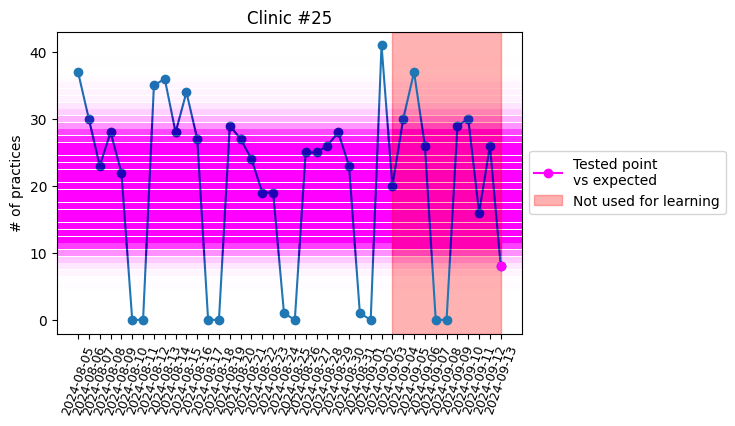

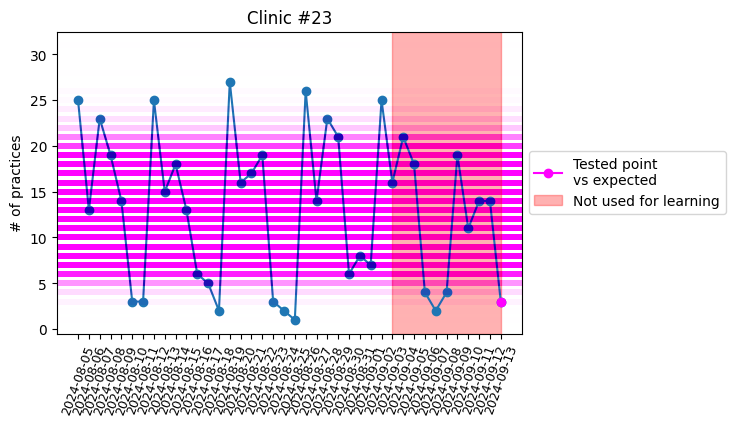

In [42]:
for name in list(probabilities)[-2:]: 
    plt.plot(np.array(data0['Date'][:]), np.array(data0[name][:]),marker='o')
    plt.plot(np.array(data0['Date'])[-1], np.array(data0[name])[-1],marker='o',color='magenta', label='Tested point\nvs expected')
    #plt.scatter(np.array(data['Fecha'])[-day_of_study-1], np.array(data[name])[-day_of_study-1],marker='o',color='magenta', label='Tested point')
    plt.axvspan(np.array(data0['Date'])[start_not_learning_block],np.array(data0['Date'])[end_not_learning_block], alpha=0.3, color='red', label='Not used for learning')
    for i in range(len(probabilities.iloc[4][name])):
    #for i in range(10):
        tmp = stats.poisson.rvs(probabilities.iloc[4][name][i], size=3)
        for j in range(len(tmp)):
            plt.axhline(tmp[j], alpha=0.003, linestyle='solid', linewidth=4,  color='magenta')
        #plt.axhline(probabilities.iloc[4][name][i], alpha=0.003, linestyle='solid', color='red')
    plt.xticks(rotation=70, fontsize=9)
    plt.ylabel('# of practices')
    plt.title(name)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

## Final comments